Word2Vec (skip-gram)
=============

In [1]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
from random import randint
import tensorflow as tf
import tflearn
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from six.moves import cPickle as pickle

hdf5 not supported (please install/reinstall h5py)


Read the data into a string.

In [2]:
pickle_file = 'words_dataset.pickle'
try:
    f = open(pickle_file, 'rb')
    words = pickle.load(f)
    f.close()
except Exception as e:
    print('Unable to read data', e)
        
print('Data size', len(words))

Data size 144221779


In [4]:
test = []
test.extend(collections.Counter(words).most_common())
print(len(test))
del test

682274


Build the dictionary and replace rare words with UNK token.

In [5]:
vocabulary_size = 600000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    data_length = len(words)
    dictionary = dict()
    frequencies = []
    for word, _ in count:
        dictionary[word] = len(dictionary)
        frequencies.append((.0 + _) / data_length)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    frequencies[0] = (.0 + unk_count) / data_length
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary, frequencies

data, count, dictionary, reverse_dictionary, frequencies = build_dataset(words)


print('Most common words: ', count[:5])
print('Sample data: ', data[:10])

discard_prob = list(range(len(frequencies)))
i = 0
for freq in frequencies:
    if math.sqrt(1e-5 / frequencies[i]) > 1:
        discard_prob[i] = 1e-5
    else:
        discard_prob[i] = (1 - math.sqrt(1e-4 / frequencies[i]))
    i += 1
    
for i in range(15):
    print('Word: {2}   Freq: {0:.5f}...   Discard prob: {1:.3f}'.format(frequencies[i], discard_prob[i], reverse_dictionary[i]))

del words  # Hint to reduce memory.

Most common words:  [['UNK', 82275], ('the', 8389780), ('of', 4099029), ('to', 4068666), ('and', 3648034)]
Sample data:  [5, 78, 2, 6953, 6, 678, 55375, 1, 487, 631]
Word: UNK   Freq: 0.00057...   Discard prob: 0.581
Word: the   Freq: 0.05817...   Discard prob: 0.959
Word: of   Freq: 0.02842...   Discard prob: 0.941
Word: to   Freq: 0.02821...   Discard prob: 0.940
Word: and   Freq: 0.02529...   Discard prob: 0.937
Word: a   Freq: 0.02384...   Discard prob: 0.935
Word: in   Freq: 0.01998...   Discard prob: 0.929
Word: that   Freq: 0.01398...   Discard prob: 0.915
Word: is   Freq: 0.01052...   Discard prob: 0.903
Word: for   Freq: 0.01020...   Discard prob: 0.901
Word: it   Freq: 0.00797...   Discard prob: 0.888
Word: on   Freq: 0.00744...   Discard prob: 0.884
Word: with   Freq: 0.00704...   Discard prob: 0.881
Word: as   Freq: 0.00615...   Discard prob: 0.873
Word: are   Freq: 0.00579...   Discard prob: 0.869


## Main variables
count = [['UNK', 'unknown count'], ('word1', 'word1 count'), ('word2', 'word2 count')...] 

frequencies = [frequency of word in count]

discard_prob = [discard probability of word in count]

dictionary = {'word' : index_in_count}

reverse_dictionary = [index_in_count : 'word']

data = [index of word in count]

In [6]:
data_length = len(data)

def get_batch(batch_size, skip_window, num_skips):
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    example_num = 0
    
    while example_num < batch_size:
        word_index = -1
    
        while word_index < 0:
            word_index = randint(0, data_length-1)
            word = data[word_index]
            if random.random() < discard_prob[word]:
                word_index = -1
                
        used_labels = []
        for i in range(num_skips):
            
            label_index = -1
            while label_index < 0 or label_index > data_length-1:
                label_index = word_index + (randint(1, skip_window) * random.choice([-1, 1]))
            label = data[label_index]
            
            if random.random() < discard_prob[label]:
                label = -1
            elif example_num < batch_size and word != label and (label not in used_labels):
                batch[example_num] = word
                labels[example_num] = label
                used_labels.append(label)
                example_num += 1

    return batch, labels

batch, labels = get_batch(batch_size=30, skip_window=2, num_skips=4)

for i in range(30):
    print(reverse_dictionary[batch[i]], reverse_dictionary[labels[i][0]])

virtual private
glasgow lithuanian
glasgow in
crystal structure
function if
function systems
hps context
hps new
is guarantee
a them
a in
secure samsungs
secure sub
sound degrees
sound project
booking convention
reram others
sd mini
sd expansion
eventually showed
eventually an
eventually six
associate terry
associate taylor
vote how
useful most
useful during
prison after
then be
then obviously


# Train a skip-gram model

In [7]:
batch_size = 256
embedding_size = 300 # Dimension of the embedding vector.
skip_window = 8 # How many words to consider left and right.
num_skips = 8 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 50 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(10, valid_window), valid_size))
num_sampled = 256 # Number of negative examples to sample.


def device_for_node(n):
    if n.type == "MatMul":
        return "/gpu:0"
    else:
        return "/cpu:0"

graph = tf.Graph()

'''
OLD
with graph.as_default(), tf.device('/cpu:0'):
'''
with graph.as_default():
    with graph.device(device_for_node):
        # Input data.
        train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

        # Variables.
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

        softmax_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))

        softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

        # Model.Look up embeddings for inputs.
        embed = tf.nn.embedding_lookup(embeddings, train_dataset)

        # Compute the softmax loss, using a sample of the negative labels each time.
        loss = tf.reduce_mean(
            tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                   train_labels, num_sampled, vocabulary_size))
        # Optimizer.
        optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

        # Compute the similarity between minibatch examples and all embeddings. We use the cosine distance:
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(
            normalized_embeddings, valid_dataset)
        similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [8]:
num_steps = 50000001
#num_steps = 5
average_loss = 0

with tf.Session(graph=graph) as session:
    
    tf.initialize_all_variables().run()
   
    for step in range(num_steps):
        batch_data, batch_labels = get_batch(batch_size, skip_window, num_skips)
    
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        
        average_loss += l
        if step % 1000000 == 0 and step != 0:

            average_loss = average_loss / 1000000
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

            sim = similarity.eval()
            for i in range(30):#valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 7 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nrst to %s: ' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
                
    final_embeddings = normalized_embeddings.eval()
    
pickle_file = 'embeddings.pickle'
try:
    f = open(pickle_file, 'wb')
    save = {'embeddings': final_embeddings}
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    print('Saved dump: ', pickle_file)
except Exception as e:
    print('Unable to save data', e)

Average loss at step  1000000 :  5.06234451966
Nrst to than:  less, much, more, slightly, fewer, smaller, twice,
Nrst to you:  your, youll, can, or, youre, lets, yourself,
Nrst to page:  visit, search, plenty, missing, recommending, you, youd,
Nrst to now:  already, but, still, recently, finally, and, have,
Nrst to science:  we, thank, about, vol, scientific, sciences, note,
Nrst to who:  whom, whose, had, being, those, and, they,
Nrst to two:  three, four, six, eight, five, seven, several,
Nrst to has:  recently, hasnt, on, of, been, since, had,
Nrst to get:  getting, give, go, find, gets, theyre, want,
Nrst to most:  especially, many, particularly, even, often, more, unlike,
Nrst to these:  many, some, those, other, several, are, various,
Nrst to even:  but, though, because, especially, actually, most, just,
Nrst to about:  we, only, so, word, just, more, note,
Nrst to research:  study, institute, studies, funded, findings, dr, director,
Nrst to had:  were, never, having, after, was,

In [9]:
# count, dictionary, reverse_dictionary, frequencies

pickle_file = 'reverse_dictionary.pickle'
try:
    f = open(pickle_file, 'wb')
    pickle.dump(reverse_dictionary, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    print('Saved dump: ', pickle_file)
except Exception as e:
    print('Unable to save data', e)
    
pickle_file = 'count.pickle'
try:
    f = open(pickle_file, 'wb')
    pickle.dump(count, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    print('Saved dump: ', pickle_file)
except Exception as e:
    print('Unable to save data', e)
    
pickle_file = 'dictionary.pickle'
try:
    f = open(pickle_file, 'wb')
    pickle.dump(dictionary, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    print('Saved dump: ', pickle_file)
except Exception as e:
    print('Unable to save data', e)
    

pickle_file = 'frequencies.pickle'
try:
    f = open(pickle_file, 'wb')
    pickle.dump(frequencies, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    print('Saved dump: ', pickle_file)
except Exception as e:
    print('Unable to save data', e)
    
pickle_file = 'embeddings.pickle'
try:
    f = open(pickle_file, 'wb')
    pickle.dump(final_embeddings, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    print('Saved dump: ', pickle_file)
except Exception as e:
    print('Unable to save data', e)

Saved dump:  reverse_dictionary.pickle
Saved dump:  count.pickle
Saved dump:  dictionary.pickle
Saved dump:  frequencies.pickle
Saved dump:  embeddings.pickle


In [9]:
num_points = 100

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

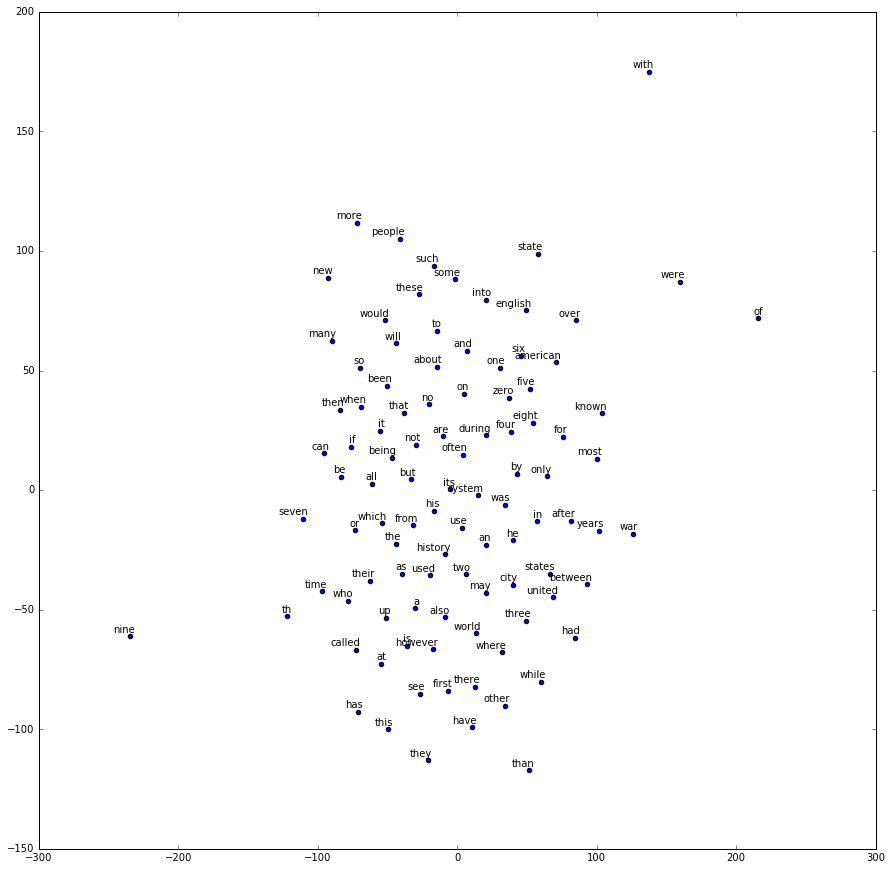

In [10]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)